# Confidence Simulations with Pilot Responses 10% Hazard

1. Read in data from PilotData4 (hazard rate 10%; survey)
2. Simulate confidences:
    1. Normative
    2. ~~Restricted normative (using subject's window)~~
    3. Normative + 20% noise
    4. ~~Restricted normative + 20% noise~~
    5. Random
3. Compute I_past, I_future for task only, task + confidence, confidence only (maybe start with one subject)
4. Compare differences/ratios of I_past for different confidence simulations
5. Compare differences/ratios of I_future for different confidence simulations

In [606]:
import importlib
#importlib.reload(sm)

<module 'smfile' from '/Users/vwang/Documents/PennMed/Gold Lab/Preregistration/Urn-Confidence/Pilot/smfile.py'>

In [414]:
import pandas as pd
import numpy as np
from embo import InformationBottleneck
import HMM_beads_utils as ut
import smfile as sm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
import os,ndd,pickle
from adjustText import adjust_text
import adjustText
cmap = plt.get_cmap("tab10")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [458]:
D = pd.read_csv("PilotData4_munged.csv", dtype = {'History': str})

In [459]:
D['Subject'].unique()
D

array(['5ebd', '5e9d', '5da7', '60ce', '5f52', '60c8'], dtype=object)

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History
0,5ebd,10,0,1,0,0,0,00011101101
1,5ebd,11,0,0,1,1,0,00111011011
2,5ebd,12,0,0,0,1,1,01110110110
3,5ebd,13,1,0,0,1,1,01101101100
4,5ebd,14,0,1,0,1,0,01011011000
...,...,...,...,...,...,...,...,...
5995,60c8,1005,0,0,1,1,0,01110111011
5996,60c8,1006,0,0,1,0,0,01101110110
5997,60c8,1007,0,0,0,0,1,01011101100
5998,60c8,1008,0,0,0,0,1,00111011000


In [460]:
for sub in D['Subject'].unique():
    subD = D[D['Subject'] == sub].reset_index()
    normative = sm.gen_sim_pred(sub,subD['Bead'],subD['Jar'],subD['Trial'],p = 0.8,h = 0.1)
    D.loc[D['Subject'] == sub, 'Prior'] = normative['Prior'].values
    #D.loc[D['Subject'] == sub, 'Posterior'] = normative['Posterior'].values
D

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History,Prior
0,5ebd,10,0,1,0,0,0,00011101101,0.500000
1,5ebd,11,0,0,1,1,0,00111011011,0.740000
2,5ebd,12,0,0,0,1,1,01110110110,0.432584
3,5ebd,13,1,0,0,1,1,01101101100,0.228067
4,5ebd,14,0,1,0,1,0,01011011000,0.155025
...,...,...,...,...,...,...,...,...,...
5995,60c8,1005,0,0,1,1,0,01110111011,0.848231
5996,60c8,1006,0,0,1,0,0,01101110110,0.566283
5997,60c8,1007,0,0,0,0,1,01011101100,0.296869
5998,60c8,1008,0,0,0,0,1,00111011000,0.176380


In [515]:
D_n = D.copy()
D_s = D.copy()
D_r = D.copy()

D_n['Confidence'] = D_n.groupby(['Subject'], group_keys=False).apply(lambda g: abs(0.5 - g.Prior) > abs(0.5 - g.Prior).median())*1
D_s['Confidence'] = sm.add_noise(D_n['Confidence'],0.1)
D_r['Confidence'] = sm.add_noise(D_n['Confidence'],0.5)

Ddict = {'orig': D, 'normative': D_n, 'normslop': D_s, 'random': D_r}

In [516]:
D['Subject'].unique()[3]

'60ce'

<Figure size 576x432 with 0 Axes>

Text(0, 0.5, 'Mutual Information between\n$X_{past}$ and $X_{future}$')

Text(0.5, 0, 'Window size of $X$ into the past')

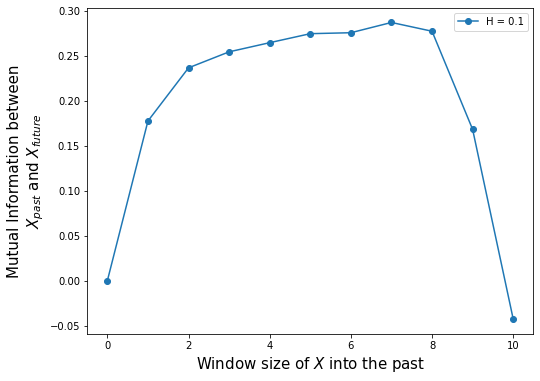

In [517]:
maxw = 10

bound_seq = D[D['Subject'] == D['Subject'].unique()[3]].copy()
bound_seq['History'] = sm.get_previous_n_beads(maxw, bound_seq['Bead'])

# Computed windowed predictive information in the low hazard rate
window_mi = sm.get_windowed_mi(bound_seq['History'],
                              bound_seq['Jar'],maxw)

# Plot predictive information as a function of window size
plt.figure(1,(8,6))
plt.plot(np.arange(maxw+1),window_mi,'-o',label='H = 0.1')
plt.ylabel('Mutual Information between\n$X_{past}$ and $X_{future}$',size=15)
plt.xlabel('Window size of $X$ into the past',size=15)
plt.legend()

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, '$I_{past}$')

Text(0, 0.5, '$I_{future}$')

Text(0.5, 1.0, 'Low confidence')

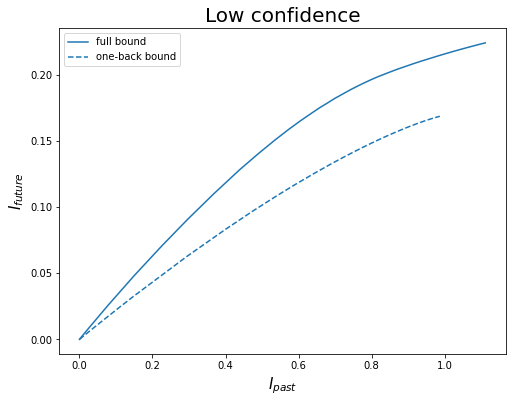

In [607]:
ip_fullbound,if_fullbound,ip_1backbound,if_1backbound = sm.get_windowed_bound(bound_seq['History'],
                                                             bound_seq['Jar'],6, maxbeta = 10)

    
# Plot bounds
plt.figure(1,(8,6))

# Low confidence rate
#plt.subplot(1,2,1)
plt.plot(ip_fullbound,if_fullbound,'-',color=cmap(0),label='full bound')
plt.plot(ip_1backbound,if_1backbound,'--',color=cmap(0), label='one-back bound')
#plt.ylim([0,.8])
plt.xlabel('$I_{past}$',size=15)
plt.ylabel('$I_{future}$',size=15)
plt.title('Low confidence',size=20)
plt.legend()

In [519]:
D

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History,Prior
0,5ebd,10,0,1,0,0,0,00011101101,0.500000
1,5ebd,11,0,0,1,1,0,00111011011,0.740000
2,5ebd,12,0,0,0,1,1,01110110110,0.432584
3,5ebd,13,1,0,0,1,1,01101101100,0.228067
4,5ebd,14,0,1,0,1,0,01011011000,0.155025
...,...,...,...,...,...,...,...,...,...
5995,60c8,1005,0,0,1,1,0,01110111011,0.848231
5996,60c8,1006,0,0,1,0,0,01101110110,0.566283
5997,60c8,1007,0,0,0,0,1,01011101100,0.296869
5998,60c8,1008,0,0,0,0,1,00111011000,0.176380


In [520]:
I_window = []

def window_helper(i_p, i_f, dname, includes):
    m = []
    for sub in i_p.keys():
        df = pd.DataFrame({
            'Subject':sub,
            'sim':dname,
            'includes':includes,
            'window':np.arange(len(i_p[sub])),
            'Ip':i_p[sub],
            'If':i_f[sub]
        })
        m.extend(df.values)
    return(m)

for dname,d in Ddict.items():
    ip_task, if_task = sm.get_windowed_mi_subs(d,6)
    ip_conf, if_conf = sm.get_windowed_mi_subs_confo(d,6)
    ip_both, if_both = sm.get_windowed_mi_subs_confid(d,6)
    
    I_window.extend(window_helper(ip_task, if_task, dname, "task"))
    I_window.extend(window_helper(ip_conf, if_conf, dname, "conf"))
    I_window.extend(window_helper(ip_both, if_both, dname, "both"))

I_window_df = pd.DataFrame(I_window, columns = ['Subject', 'sim', 'includes', 'window', 'Ip', "If"])
I_window_df

,Subject,sim,includes,window,Ip,If
0,5ebd,orig,task,0,0.000000,0.151968
1,5ebd,orig,task,1,0.390080,0.151968
2,5ebd,orig,task,2,0.608519,0.151968
3,5ebd,orig,task,3,0.639487,0.151968
4,5ebd,orig,task,4,0.679021,0.151968
...,...,...,...,...,...,...
499,60c8,random,both,2,0.561634,0.153523
500,60c8,random,both,3,0.619266,0.153523
501,60c8,random,both,4,0.615790,0.153523
502,60c8,random,both,5,0.608216,0.153523


In [521]:
nboot = 10
Ip_boot = []
If_boot = []

def boot_helper(ip_boot, dname, includes):
    df = pd.DataFrame({
        'Subject':ip_boot.keys(),
        'sim':dname,
        'includes':includes,
        'mean':np.array([np.mean(ip_boot[key]) for key in ip_boot.keys()]),
        '95CI':np.array([np.std(ip_boot[key])*1.96 for key in ip_boot.keys()])
    })
    return(df)

for dname,d in Ddict.items():
    ip_task, if_task = sm.get_windowed_mi_subs(d,6)
    ip_conf, if_conf = sm.get_windowed_mi_subs_confo(d,6)
    ip_both, if_both = sm.get_windowed_mi_subs_confid(d,6)
    
    ip_task_boot, if_task_boot = sm.get_bootstrapped_samples(d,ip_task,nboot)
    ip_conf_boot, if_conf_boot = sm.get_bootstrapped_samples_confo(d,ip_conf,nboot)
    ip_both_boot, if_both_boot = sm.get_bootstrapped_samples_confid(d,ip_both,nboot)
    
    Ip_boot.extend(boot_helper(ip_task_boot, dname, "task").values)
    Ip_boot.extend(boot_helper(ip_conf_boot, dname, "conf").values)
    Ip_boot.extend(boot_helper(ip_both_boot, dname, "both").values)
    If_boot.extend(boot_helper(if_task_boot, dname, "task").values)
    If_boot.extend(boot_helper(if_conf_boot, dname, "conf").values)
    If_boot.extend(boot_helper(if_both_boot, dname, "both").values)

Ip_boot_df = pd.DataFrame(Ip_boot, columns = ['Subject', 'sim', 'includes', 'mean', '95CI'])
If_boot_df = pd.DataFrame(If_boot, columns = ['Subject', 'sim', 'includes', 'mean', '95CI'])

In [522]:
Ip_boot_df
If_boot_df

,Subject,sim,includes,mean,95CI
0,5ebd,orig,task,0.748679,0.057656
1,5e9d,orig,task,0.626669,0.065543
2,5da7,orig,task,0.717206,0.047992
3,60ce,orig,task,0.920656,0.033772
4,5f52,orig,task,0.728365,0.033004
...,...,...,...,...,...
67,5e9d,random,both,0.763578,0.064174
68,5da7,random,both,0.842957,0.044130
69,60ce,random,both,1.032733,0.040054
70,5f52,random,both,0.857657,0.044421


,Subject,sim,includes,mean,95CI
0,5ebd,orig,task,0.151334,0.035907
1,5e9d,orig,task,0.112114,0.018552
2,5da7,orig,task,0.188783,0.028437
3,60ce,orig,task,0.217828,0.050133
4,5f52,orig,task,0.175182,0.035401
...,...,...,...,...,...
67,5e9d,random,both,0.107222,0.027457
68,5da7,random,both,0.186864,0.037418
69,60ce,random,both,0.223292,0.043193
70,5f52,random,both,0.158924,0.046925


In [523]:
I_window_df['includes'].unique()

array(['task', 'conf', 'both'], dtype=object)

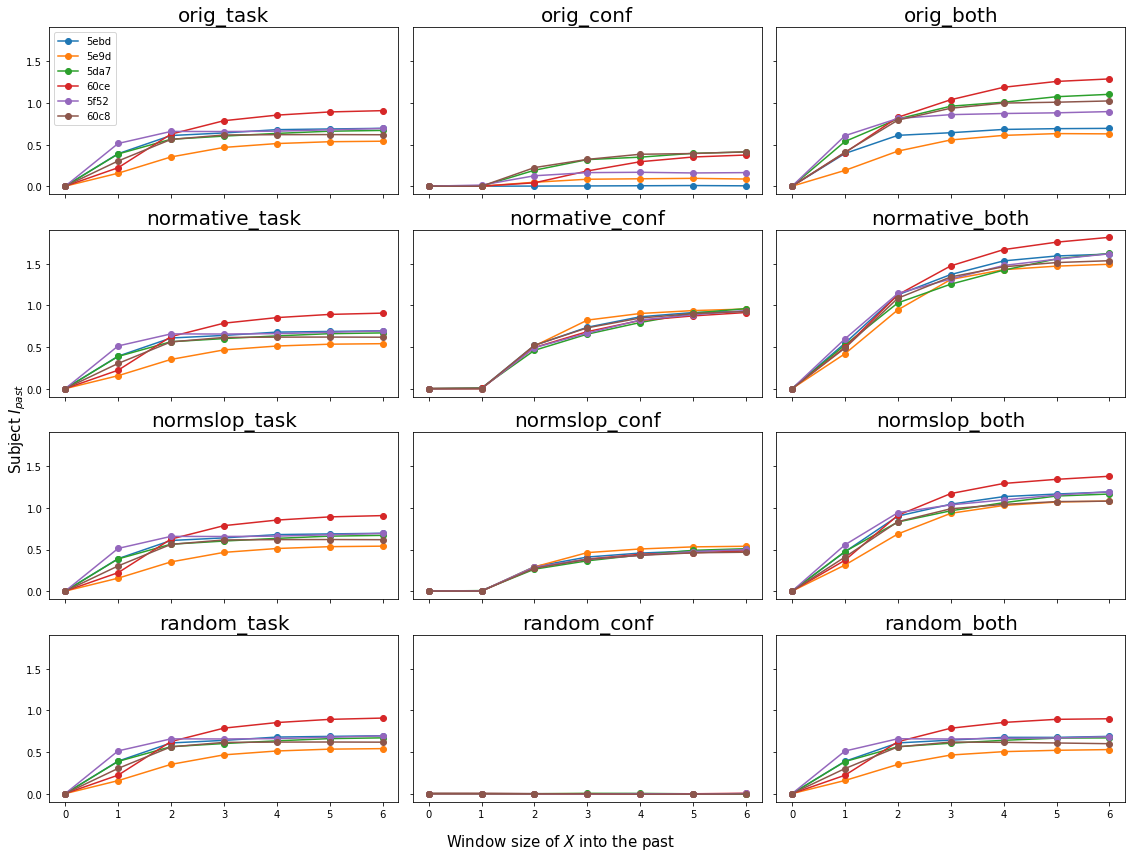

In [524]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(16, 12), sharex = True, sharey = True)
for i,sim in enumerate(I_window_df['sim'].unique()):
    for j,includes in enumerate(I_window_df['includes'].unique()):
        Itype = I_window_df[(I_window_df['sim'] == sim) & (I_window_df['includes'] == includes)]
        for sub in Itype['Subject'].unique():
            Isub = Itype[Itype['Subject'] == sub]
            axs[i,j].plot(Isub['window'],Isub['Ip'],'-o',label = sub)
        axs[i,j].set_title(sim + "_" + includes,size=20)
axs[0,0].legend(loc = 'upper left')        
fig.supxlabel('Window size of $X$ into the past',size=15)
fig.supylabel('Subject $I_{past}$',size=15)
#plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show();

In [525]:
boot_data_full = pd.merge(Ip_boot_df,If_boot_df, on = ['Subject','sim','includes'], suffixes = ['_ip', '_if'])

In [526]:
#colors = dict(zip(set(Ip_boot_df['Subject'].unique()), [cmap(i) for i in np.arange(len(Ip_boot_df['Subject'].unique()))]))
colors = dict(zip(set(Ip_boot_df['includes'].unique()), [cmap(i) for i in np.arange(len(Ip_boot_df['includes'].unique()))]))

boot_data_full['color'] = boot_data_full['includes'].map(colors)
#boot_data_full['label'] = boot_data_full['Subject'] + "_" + boot_data_full['sim'] + "_" + boot_data_full['includes']
boot_data_full['label'] = boot_data_full['sim']

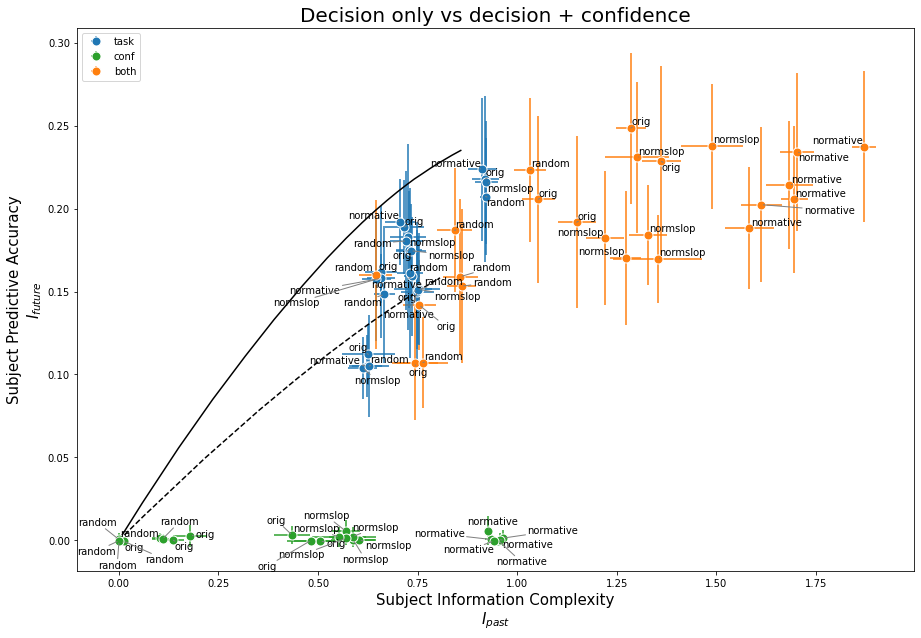

In [527]:
#sum(Ip_boot_df['label'] == If_boot_df['label'])
boot_data = boot_data_full#[boot_data_full['Subject'] == boot_data_full['Subject'].unique()[2]]

fig = plt.figure(1,(15,10))
ax = fig.add_subplot(111)
r,p=spearmanr(Ip_boot_df['mean'],If_boot_df['mean'])
ax.plot(ip_fullbound,if_fullbound,'-k')
ax.plot(ip_1backbound,if_1backbound,'--k')
texts = []
for index,row in boot_data.iterrows():
    ax.errorbar(row['mean_ip'],row['mean_if'],xerr=row['95CI_ip'],yerr = row['95CI_if'],
             marker='o',markersize=9,mec='white',color=row['color'],ls='none', label = row['includes'])
    texts.append(ax.text(row['mean_ip'],row['mean_if'],row['label'])) 
adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'))
ax.legend()
handles, labels = ax.get_legend_handles_labels()  
lgd = dict(zip(labels, handles))
ax.legend(lgd.values(), lgd.keys(), loc = "upper left")
plt.ylabel('Subject Predictive Accuracy\n$I_{future}$',size=15)
plt.xlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.title('Decision only vs decision + confidence',size=20)
plt.show;

In [528]:
colors

{'task': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 'both': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 'conf': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)}

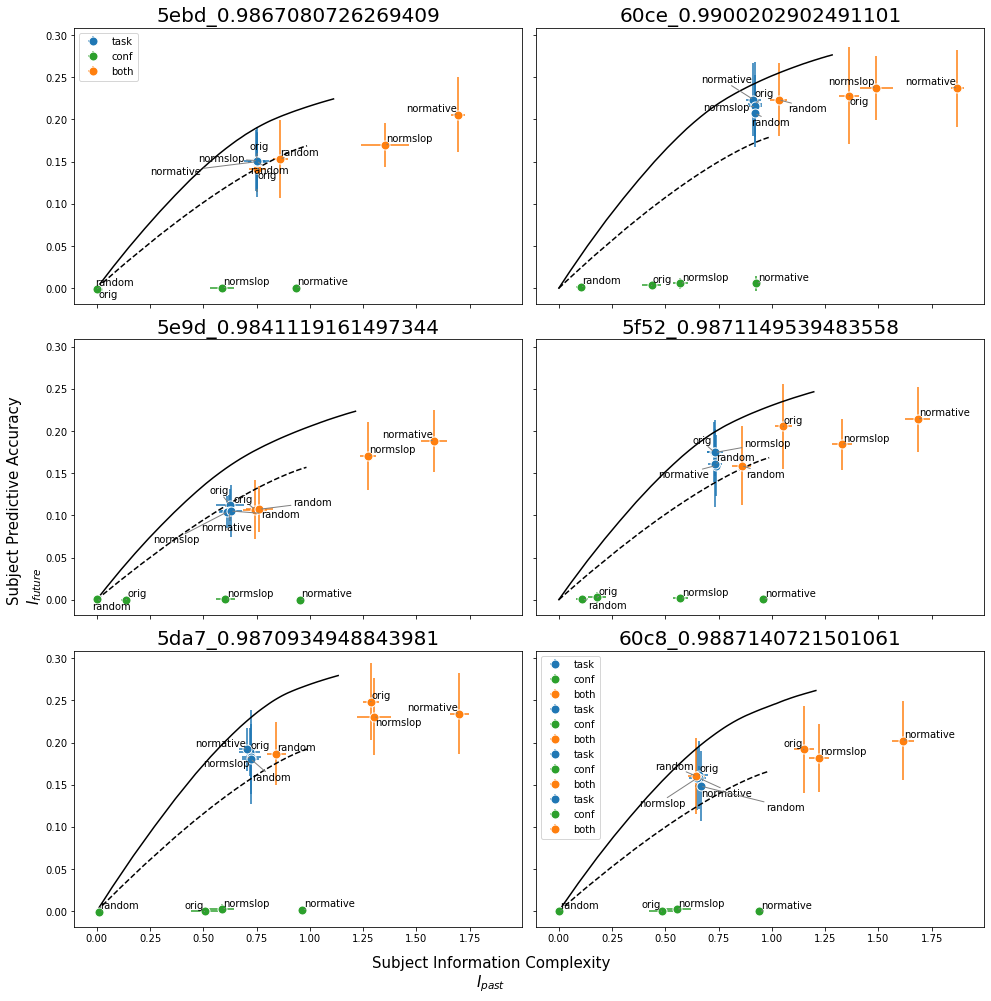

In [609]:
#sum(Ip_boot_df['label'] == If_boot_df['label'])
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 14), sharex = True, sharey = True)
texts = [[] for i in np.arange(len(boot_data_full['Subject'].unique()))] 
for i,sub in enumerate(boot_data_full['Subject'].unique()):
    boot_data = boot_data_full[boot_data_full['Subject'] == sub]
    bound_seq = D[D['Subject'] == sub]
    ip_fullbound,if_fullbound,ip_1backbound,if_1backbound = sm.get_windowed_bound(bound_seq['History'],
                                                             bound_seq['Jar'],6,maxbeta = 10)
    axs[i%3,int(i/3)].plot(ip_fullbound,if_fullbound,'-k')
    axs[i%3,int(i/3)].plot(ip_1backbound,if_1backbound,'--k')
    for index,row in boot_data.iterrows():
        axs[i%3,int(i/3)].errorbar(row['mean_ip'],row['mean_if'],xerr=row['95CI_ip'],yerr = row['95CI_if'],
                 marker='o',markersize=9,mec='white',color=row['color'],ls='none',label=row['includes'])
        texts[i].append(axs[i%3,int(i/3)].text(row['mean_ip'],row['mean_if'],row['label']))
    adjust_text(texts[i], ax = axs[i%3,int(i/3)],arrowprops=dict(arrowstyle="-",color='grey'))
    axs[i%3,int(i/3)].set_title(sub + "_" + str(max(ip_1backbound)),size=20)
#    axs[i%3,int(i/3)].text(0, 0.15, r'$\frac{Ip_{conf}}{Ip_{task} = }$' + 
#                boot_data[(boot_data['includes'] == "conf") & (boot_data['sim'] == orig)]/boot_data[(boot_data['includes'] == "conf") & (boot_data['sim'] == orig)], fontsize=15)
fig.supylabel('Subject Predictive Accuracy\n$I_{future}$',size=15)
fig.supxlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.legend(loc = "upper left")
#fig.suptitle('Decision only vs decision + confidence',size=20)
axs[0,0].legend()
handles, labels = axs[0,0].get_legend_handles_labels()  
lgd = dict(zip(labels, handles))
axs[0,0].legend(lgd.values(), lgd.keys(),loc = 'upper left')
plt.tight_layout()
plt.show;

In [610]:
melted_boot = boot_data_full[['Subject', 'sim', 'includes', 'mean_ip', 'mean_if']]\
.melt(id_vars = ['Subject', 'sim', 'includes'])\
.assign(variable = lambda g: [i.split("_")[1] for i in g.variable])\
.rename(columns={"value": "mean"})

In [611]:
Ifuture_both

,Subject,sim,Ifuture_both
84,5ebd,orig,0.141791
85,5e9d,orig,0.106856
86,5da7,orig,0.248470
87,60ce,orig,0.228383
88,5f52,orig,0.205541
89,60c8,orig,0.191713


In [612]:
Ifuture_both = melted_boot[(melted_boot['sim'] == "orig") & (melted_boot['includes'] == "both") & (melted_boot['variable'] == "if")]\
.rename(columns={"mean":"Ifuture_both"})\
.drop(columns=['variable', 'includes'])
Ifuture_task = melted_boot[(melted_boot['sim'] == "orig") & (melted_boot['includes'] == "task") & (melted_boot['variable'] == "if")]\
.rename(columns={"mean":"Ifuture_task"})\
.drop(columns=['variable', 'includes'])
Ipast_task = melted_boot[(melted_boot['sim'] == "orig") & (melted_boot['includes'] == "task") & (melted_boot['variable'] == "ip")]\
.rename(columns={"mean":"Ipast_task"})\
.drop(columns=['variable', 'includes'])

In [631]:
IBtable = Ifuture_both.merge(Ifuture_task)\
.merge(Ipast_task)\
.assign(ratio = lambda d: d.Ifuture_both/d.Ifuture_task)\
.assign(diff = lambda d: d.Ifuture_both - d.Ifuture_task)

In [632]:
D

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History,Prior
0,5ebd,10,0,1,0,0,0,00011101101,0.500000
1,5ebd,11,0,0,1,1,0,00111011011,0.740000
2,5ebd,12,0,0,0,1,1,01110110110,0.432584
3,5ebd,13,1,0,0,1,1,01101101100,0.228067
4,5ebd,14,0,1,0,1,0,01011011000,0.155025
...,...,...,...,...,...,...,...,...,...
5995,60c8,1005,0,0,1,1,0,01110111011,0.848231
5996,60c8,1006,0,0,1,0,0,01101110110,0.566283
5997,60c8,1007,0,0,0,0,1,01011101100,0.296869
5998,60c8,1008,0,0,0,0,1,00111011000,0.176380


In [633]:
#IBtable = IBtable.drop(3).reset_index(drop = True)
IBtable

,Subject,sim,Ifuture_both,Ifuture_task,Ipast_task,ratio,diff
0,5ebd,orig,0.141791,0.151334,0.748679,0.936940,-0.009543
1,5e9d,orig,0.106856,0.112114,0.626669,0.953103,-0.005258
2,5da7,orig,0.248470,0.188783,0.717206,1.316165,0.059687
3,60ce,orig,0.228383,0.217828,0.920656,1.048459,0.010556
4,5f52,orig,0.205541,0.175182,0.728365,1.173299,0.030359
5,60c8,orig,0.191713,0.161617,0.658804,1.186224,0.030097


In [635]:
def DTB(seq,ipast,ifuture):
    ''' 
    Function to calculate vertical distance from the bound between an empirical IB and participant predictive info
    ipast: participant ipast (uncorrected)
    ifuture: participant ifuture (uncorrected)
    
    Returns participant ifuture minus the empirical bound (more negative = farther away from the bound)
    '''
    ip_fullbound,if_fullbound,_,_ = sm.get_windowed_bound(seq['History'],seq['Jar'],6,maxbeta = 6)
    ind = np.argwhere(np.array(ip_fullbound) > ipast)[0][0]
    slp = (if_fullbound[ind]-if_fullbound[ind-1])/(ip_fullbound[ind]-ip_fullbound[ind-1])
    intercept = if_fullbound[ind]-(slp*ip_fullbound[ind])
    #Return distance between participant Ifuture and interpolated bound
    return ifuture - ((ipast*slp)+intercept)

# Compute distance from the bound for each subject in each hazard rate condition
IBtable['DTB'] = np.zeros(len(IBtable['Subject'].unique()))
for i,entry in IBtable.iterrows():
    IBtable['DTB'][i] = DTB(D[D['Subject'] == entry['Subject']],entry['Ipast_task'],entry['Ifuture_task'])


/Users/vwang/anaconda3/envs/ndd/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [636]:
IBtable

,Subject,sim,Ifuture_both,Ifuture_task,Ipast_task,ratio,diff,DTB
0,5ebd,orig,0.141791,0.151334,0.748679,0.936940,-0.009543,-0.038553
1,5e9d,orig,0.106856,0.112114,0.626669,0.953103,-0.005258,-0.047182
2,5da7,orig,0.248470,0.188783,0.717206,1.316165,0.059687,-0.039530
3,60ce,orig,0.228383,0.217828,0.920656,1.048459,0.010556,-0.024980
4,5f52,orig,0.205541,0.175182,0.728365,1.173299,0.030359,-0.023288
5,60c8,orig,0.191713,0.161617,0.658804,1.186224,0.030097,-0.033958


<Figure size 720x360 with 0 Axes>

<AxesSubplot:>

6

Text(48.5, 0.5, 'Subject Distance from Full Bound')

Text(0.5, 24.0, 'Subject Information Complexity\n$I_{past}$')

(0.0, 1.0)

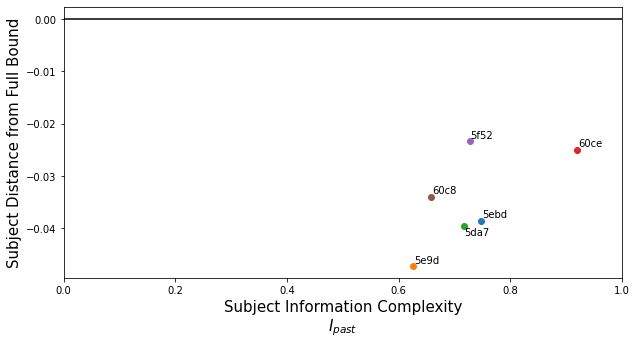

In [638]:
    # Plot distance from the bound for each hazard rate
plt.figure(1,(10,5))
# Low hazard
plt.subplot(111)
r,p=spearmanr(IBtable['Ipast_task'],IBtable['DTB'])
plt.plot([0,1],[0,0],'-k',label='full bound')
texts = []
for index,row in IBtable.iterrows():
        plt.plot(row['Ipast_task'],row['DTB'],label = row['Subject'], marker = "o")
        texts.append(plt.text(row['Ipast_task'],row['DTB'],row['Subject'])) 
adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'))
plt.ylabel('Subject Distance from Full Bound',size=15)
plt.xlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.xlim([0,1])
#plt.ylim([-.5,.12])

In [595]:
IBtable

,Subject,sim,Ifuture_both,Ifuture_task,Ipast_task,ratio,diff,DTB
0,5ebd,orig,0.141791,0.151334,0.748679,0.936940,-0.009543,-0.038545
1,5e9d,orig,0.106856,0.112114,0.626669,0.953103,-0.005258,-0.047185
2,5da7,orig,0.248470,0.188783,0.717206,1.316165,0.059687,-0.039537
3,5f52,orig,0.205541,0.175182,0.728365,1.173299,0.030359,-0.023284
4,60c8,orig,0.191713,0.161617,0.658804,1.186224,0.030097,-0.033944


In [639]:
IBtable\
.drop(columns = ['sim', 'Ifuture_both', 'Ifuture_task'])\
#.to_csv("../UrnConfidenceQuestionnaire/Data/IBtable.csv", index=False)

In [500]:
C = D[D['Subject'] == "5da7"].copy().reset_index(drop = True)
C = C.assign(Response = 1 * (C['Prior'] > 0.5))
C = C.assign(Confidence = (abs(0.5 - C['Prior']) > abs(0.5 - C['Prior']).median())*1)

In [501]:
C

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History,Prior
0,5da7,10,0,0,0,0,0,00000011001,0.500000
1,5da7,11,0,0,0,0,1,00000110010,0.260000
2,5da7,12,0,0,0,1,1,00001100100,0.164596
3,5da7,13,0,0,0,1,1,00011001000,0.137555
4,5da7,14,0,0,0,1,0,00110010000,0.130676
...,...,...,...,...,...,...,...,...,...
995,5da7,1005,0,1,0,1,0,00000100100,0.155275
996,5da7,1006,0,0,0,0,1,00001001001,0.438976
997,5da7,1007,1,1,0,0,0,00010010010,0.230887
998,5da7,1008,1,1,1,0,0,00100100101,0.536496


In [502]:
C_both = C.copy()
C_confid = C.assign(Response = sm.add_noise(C['Response'],0.5))
C_task = C.assign(Confidence = sm.add_noise(C['Confidence'],0.5))
C_none = C.assign(Confidence = sm.add_noise(C['Confidence'],0.5), Response = sm.add_noise(C['Response'],0.5))
Ddict = {'none': C_none, 'task': C_task, 'confid': C_confid, 'both': C_both}

<Figure size 576x432 with 0 Axes>

Text(0, 0.5, 'Mutual Information between\n$X_{past}$ and $X_{future}$')

Text(0.5, 0, 'Window size of $X$ into the past')

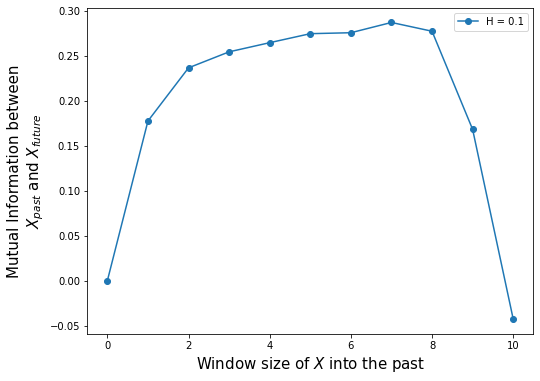

In [503]:
maxw = 10

bound_seq = D[D['Subject'] == D['Subject'].unique()[3]].copy()
bound_seq['History'] = sm.get_previous_n_beads(maxw, bound_seq['Bead'])

# Computed windowed predictive information in the low hazard rate
window_mi = sm.get_windowed_mi(bound_seq['History'],
                              bound_seq['Jar'],maxw)

# Plot predictive information as a function of window size
plt.figure(1,(8,6))
plt.plot(np.arange(maxw+1),window_mi,'-o',label='H = 0.1')
plt.ylabel('Mutual Information between\n$X_{past}$ and $X_{future}$',size=15)
plt.xlabel('Window size of $X$ into the past',size=15)
plt.legend()

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, '$I_{past}$')

Text(0, 0.5, '$I_{future}$')

Text(0.5, 1.0, 'Low confidence')

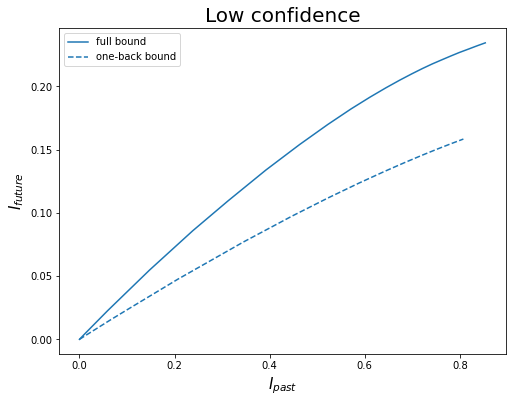

In [504]:
ip_fullbound,if_fullbound,ip_1backbound,if_1backbound = sm.get_windowed_bound(bound_seq['History'],
                                                             bound_seq['Jar'],6)

    
# Plot bounds
plt.figure(1,(8,6))

# Low confidence rate
#plt.subplot(1,2,1)
plt.plot(ip_fullbound,if_fullbound,'-',color=cmap(0),label='full bound')
plt.plot(ip_1backbound,if_1backbound,'--',color=cmap(0), label='one-back bound')
#plt.ylim([0,.8])
plt.xlabel('$I_{past}$',size=15)
plt.ylabel('$I_{future}$',size=15)
plt.title('Low confidence',size=20)
plt.legend()

In [505]:
D

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History,Prior
0,5ebd,10,0,1,0,0,0,00011101101,0.500000
1,5ebd,11,0,0,1,1,0,00111011011,0.740000
2,5ebd,12,0,0,0,1,1,01110110110,0.432584
3,5ebd,13,1,0,0,1,1,01101101100,0.228067
4,5ebd,14,0,1,0,1,0,01011011000,0.155025
...,...,...,...,...,...,...,...,...,...
5995,60c8,1005,0,0,1,1,0,01110111011,0.848231
5996,60c8,1006,0,0,1,0,0,01101110110,0.566283
5997,60c8,1007,0,0,0,0,1,01011101100,0.296869
5998,60c8,1008,0,0,0,0,1,00111011000,0.176380


In [506]:
I_window = []

def window_helper(i_p, i_f, dname, includes):
    m = []
    for sub in i_p.keys():
        df = pd.DataFrame({
            'Subject':sub,
            'sim':dname,
            'includes':includes,
            'window':np.arange(len(i_p[sub])),
            'Ip':i_p[sub],
            'If':i_f[sub]
        })
        m.extend(df.values)
    return(m)

for dname,d in Ddict.items():
    ip_task, if_task = sm.get_windowed_mi_subs(d,6)
    ip_conf, if_conf = sm.get_windowed_mi_subs_confo(d,6)
    ip_both, if_both = sm.get_windowed_mi_subs_confid(d,6)
    
    I_window.extend(window_helper(ip_task, if_task, dname, "task"))
    I_window.extend(window_helper(ip_conf, if_conf, dname, "conf"))
    I_window.extend(window_helper(ip_both, if_both, dname, "both"))

I_window_df = pd.DataFrame(I_window, columns = ['Subject', 'sim', 'includes', 'window', 'Ip', "If"])
I_window_df

,Subject,sim,includes,window,Ip,If
0,5da7,none,task,0,0.000000,-0.000863
1,5da7,none,task,1,-0.000590,-0.000863
2,5da7,none,task,2,-0.001097,-0.000863
3,5da7,none,task,3,-0.003215,-0.000863
4,5da7,none,task,4,-0.008060,-0.000863
...,...,...,...,...,...,...
79,5da7,both,both,2,1.114035,0.255050
80,5da7,both,both,3,1.491435,0.255050
81,5da7,both,both,4,1.718187,0.255050
82,5da7,both,both,5,1.856664,0.255050


In [507]:
nboot = 100
Ip_boot = []
If_boot = []

def boot_helper(ip_boot, dname, includes):
    df = pd.DataFrame({
        'Subject':ip_boot.keys(),
        'sim':dname,
        'includes':includes,
        'mean':np.array([np.mean(ip_boot[key]) for key in ip_boot.keys()]),
        '95CI':np.array([np.std(ip_boot[key])*1.96 for key in ip_boot.keys()])
    })
    return(df)

for dname,d in Ddict.items():
    ip_task, if_task = sm.get_windowed_mi_subs(d,6)
    ip_conf, if_conf = sm.get_windowed_mi_subs_confo(d,6)
    ip_both, if_both = sm.get_windowed_mi_subs_confid(d,6)
    
    ip_task_boot, if_task_boot = sm.get_bootstrapped_samples(d,ip_task,nboot)
    ip_conf_boot, if_conf_boot = sm.get_bootstrapped_samples_confo(d,ip_conf,nboot)
    ip_both_boot, if_both_boot = sm.get_bootstrapped_samples_confid(d,ip_both,nboot)
    
    Ip_boot.extend(boot_helper(ip_task_boot, dname, "task").values)
    Ip_boot.extend(boot_helper(ip_conf_boot, dname, "conf").values)
    Ip_boot.extend(boot_helper(ip_both_boot, dname, "both").values)
    If_boot.extend(boot_helper(if_task_boot, dname, "task").values)
    If_boot.extend(boot_helper(if_conf_boot, dname, "conf").values)
    If_boot.extend(boot_helper(if_both_boot, dname, "both").values)

Ip_boot_df = pd.DataFrame(Ip_boot, columns = ['Subject', 'sim', 'includes', 'mean', '95CI'])
If_boot_df = pd.DataFrame(If_boot, columns = ['Subject', 'sim', 'includes', 'mean', '95CI'])

In [508]:
Ip_boot_df
If_boot_df

,Subject,sim,includes,mean,95CI
0,5da7,none,task,-0.000029,0.001957
1,5da7,none,conf,0.001924,0.006151
2,5da7,none,both,0.262220,0.061065
3,5da7,task,task,0.962486,0.012704
4,5da7,task,conf,0.098620,0.039575
5,5da7,task,both,1.055401,0.040269
6,5da7,confid,task,0.000723,0.003961
7,5da7,confid,conf,0.967168,0.011909
8,5da7,confid,both,1.054534,0.047461
9,5da7,both,task,0.963202,0.012248


,Subject,sim,includes,mean,95CI
0,5da7,none,task,-0.000170,0.001998
1,5da7,none,conf,0.001380,0.004984
2,5da7,none,both,0.000287,0.005243
3,5da7,task,task,0.222827,0.045344
4,5da7,task,conf,0.000411,0.003029
5,5da7,task,both,0.223691,0.042455
6,5da7,confid,task,-0.000260,0.001771
7,5da7,confid,conf,0.000942,0.004512
8,5da7,confid,both,0.000433,0.006373
9,5da7,both,task,0.219870,0.040396


In [509]:
I_window_df['includes'].unique()

array(['task', 'conf', 'both'], dtype=object)

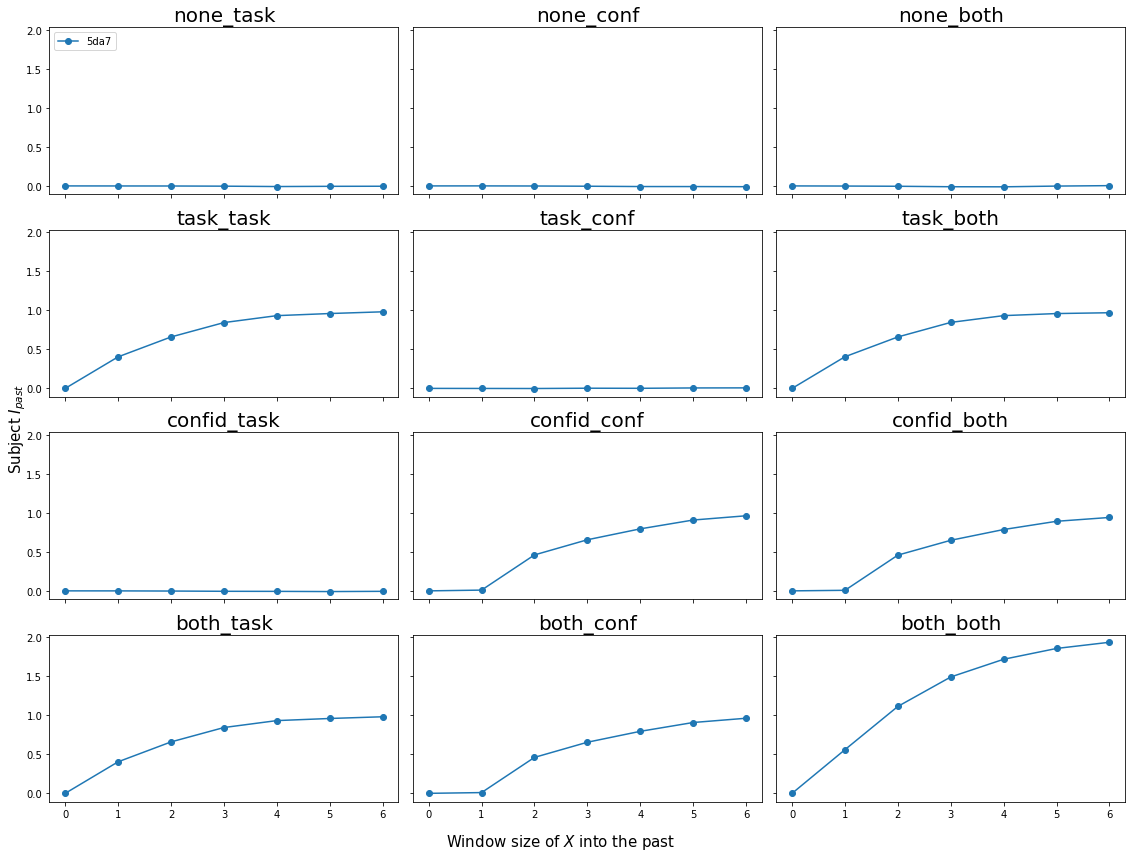

In [510]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(16, 12), sharex = True, sharey = True)
for i,sim in enumerate(I_window_df['sim'].unique()):
    for j,includes in enumerate(I_window_df['includes'].unique()):
        Itype = I_window_df[(I_window_df['sim'] == sim) & (I_window_df['includes'] == includes)]
        for sub in Itype['Subject'].unique():
            Isub = Itype[Itype['Subject'] == sub]
            axs[i,j].plot(Isub['window'],Isub['Ip'],'-o',label = sub)
        axs[i,j].set_title(sim + "_" + includes,size=20)
axs[0,0].legend(loc = 'upper left')        
fig.supxlabel('Window size of $X$ into the past',size=15)
fig.supylabel('Subject $I_{past}$',size=15)
#plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show();

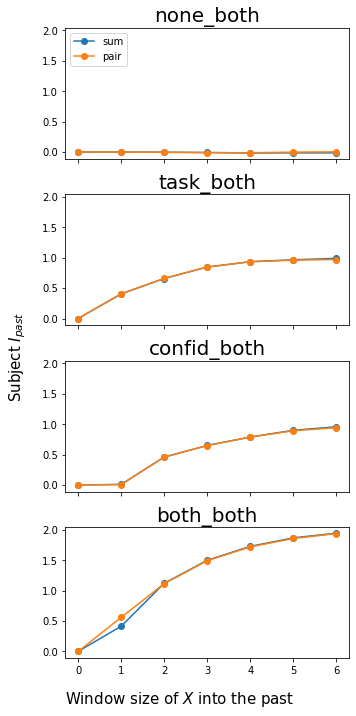

In [511]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(5, 10), sharex = True, sharey = True)
for i,sim in enumerate(I_window_df['sim'].unique()):
    includes = "both"
    Itype = I_window_df[(I_window_df['sim'] == sim) & (I_window_df['includes'] == includes)]
    for sub in Itype['Subject'].unique():
        Isub = Itype[Itype['Subject'] == sub]
        axs[i].plot(Isub['window'],[sum(i) for i in zip(I_window_df[(I_window_df['sim'] == sim) & (I_window_df['includes'] == "task")]['Ip'],I_window_df[(I_window_df['sim'] == sim) & (I_window_df['includes'] == "conf")]['Ip'])],'-o',label = "sum")
        axs[i].plot(Isub['window'],Isub['Ip'],'-o',label = "pair")
        #axs[i].plot(Isub['window'],I_window_df[(I_window_df['sim'] == sim) & (I_window_df['includes'] == "conf")]['Ip'],'-o',label = "conf")
        #axs[i].plot(Isub['window'],I_window_df[(I_window_df['sim'] == sim) & (I_window_df['includes'] == "task")]['Ip'],'-o',label = "task")
    axs[i].set_title(sim + "_" + includes,size=20)
axs[0].legend(loc = 'upper left')        
fig.supxlabel('Window size of $X$ into the past',size=15)
fig.supylabel('Subject $I_{past}$',size=15)
#plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show();

In [512]:
boot_data_full = pd.merge(Ip_boot_df,If_boot_df, on = ['Subject','sim','includes'], suffixes = ['_ip', '_if'])

In [513]:
#colors = dict(zip(set(Ip_boot_df['Subject'].unique()), [cmap(i) for i in np.arange(len(Ip_boot_df['Subject'].unique()))]))
colors = dict(zip(set(Ip_boot_df['includes'].unique()), [cmap(i) for i in np.arange(len(Ip_boot_df['includes'].unique()))]))

boot_data_full['color'] = boot_data_full['includes'].map(colors)
#boot_data_full['label'] = boot_data_full['Subject'] + "_" + boot_data_full['sim'] + "_" + boot_data_full['includes']
boot_data_full['label'] = boot_data_full['sim']

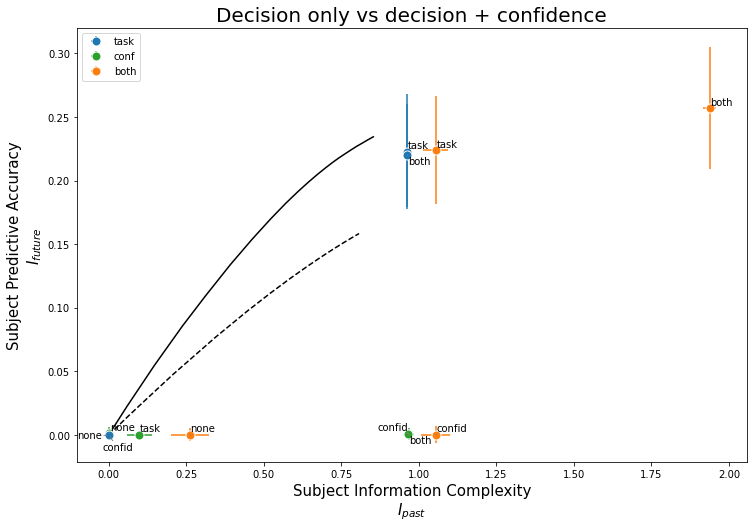

In [514]:
#sum(Ip_boot_df['label'] == If_boot_df['label'])
boot_data = boot_data_full#[boot_data_full['Subject'] == boot_data_full['Subject'].unique()[2]]

fig = plt.figure(1,(12,8))
ax = fig.add_subplot(111)
r,p=spearmanr(Ip_boot_df['mean'],If_boot_df['mean'])
ax.plot(ip_fullbound,if_fullbound,'-k')
ax.plot(ip_1backbound,if_1backbound,'--k')
texts = []
for index,row in boot_data.iterrows():
    ax.errorbar(row['mean_ip'],row['mean_if'],xerr=row['95CI_ip'],yerr = row['95CI_if'],
             marker='o',markersize=9,mec='white',color=row['color'],ls='none', label = row['includes'])
    texts.append(ax.text(row['mean_ip'],row['mean_if'],row['label'])) 
adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'))
ax.legend()
handles, labels = ax.get_legend_handles_labels()  
lgd = dict(zip(labels, handles))
ax.legend(lgd.values(), lgd.keys(), loc = "upper left")
plt.ylabel('Subject Predictive Accuracy\n$I_{future}$',size=15)
plt.xlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.title('Decision only vs decision + confidence',size=20)
plt.show;

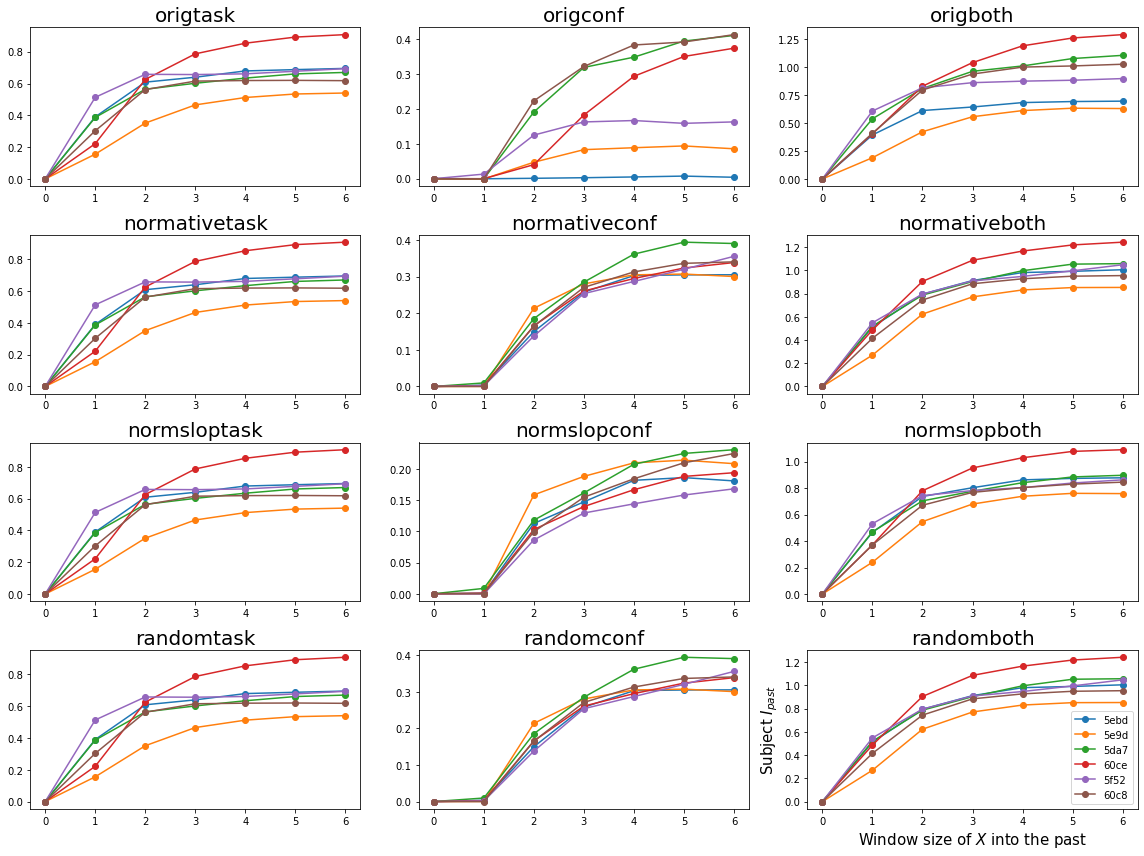

In [286]:
plt.figure(1,(16,12))
for i,sim in enumerate(I_window_df['sim'].unique()):
    for j,includes in enumerate(I_window_df['includes'].unique()):
        plt.subplot(4, 3, 3*i + j + 1)
        Itype = I_window_df[(I_window_df['sim'] == sim) & (I_window_df['includes'] == includes)]
        for sub in Itype['Subject'].unique():
            Isub = Itype[Itype['Subject'] == sub]
            plt.plot(Isub['window'],Isub['Ip'],'-o',label = sub)
        plt.title(sim + includes,size=20)
        #plt.ylim([0,1])            

plt.xlabel('Window size of $X$ into the past',size=15)
plt.ylabel('Subject $I_{past}$',size=15)
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show();
